This script process statistics related to the experiments ran from the benchmark created 

TODO: Agregar urls, referencias, etc...


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon as wilcoxon
from scipy.stats import stats 

Atributes that are going to be considered for tracking during iterations

In [80]:
# Data that we'll keep track of

CLASES = [
#     "org.openscience.cdk.index.CASNumber",
#     "se.kth.cid.identity.ResourceURL",
#     "se.kth.cid.identity.URI",
#     "se.kth.cid.identity.URIClassifier",
#     "se.kth.cid.identity.URIUtil",
#     "se.kth.cid.identity.PathURN",
#     "se.kth.cid.identity.URN",
#     "se.kth.cid.identity.MIMEType",
#     "stempeluhr.validation.TimeChecker",
#     "org.jxpfw.util.InternationalBankAccountNumber",
#     "org.jxpfw.util.CLocale",
#     "com.prowidesoftware.swift.model.IBAN",
#     "com.prowidesoftware.swift.model.BIC",
#     "com.sun.jndi.toolkit.url.ConcreteURLContext",
#     "java.util.regex.Pattern",
#     "java.util.ArrayList",
#     "org.apache.commons.cli.CommandLine",
#     "org.jdom.Attribute",
#     "org.apache.commons.codec.language.DoubleMetaphone",
#     "org.joda.time.DateTime",
    "org.joda.time.format.DateTimeFormat",
#     "org.jgrapht.alg.BellmanFordIterator",
#     "org.apache.commons.math3.transform.FastFourierTransformer",
#     "net.n3.nanoxml.XMLElement"
]

TIME_ATTRS = [
    "Time_Check JUnit",
    "Time_Coverage Analysis",
    "Time_Done",
    "Time_Generating assertions",
    "Time_Initializing",
    "Time_Inlining",
    "Time_JUnit",
    "Time_Minimizing",
    "Time_Search",
]

COLUMNS = [
    "Coverage",
    "QueryCacheCalls",
    "QueryCacheHitRate",
#     "TotalNumberOfConstraints", No longer supported
    "TotalTimeSpentExecutingConcolicaly",
    "TotalTimeSpentExecutingTestCases",
    "TotalTimeSpentExecutingNonConcolicTestCases",
    "TotalTimeSpentSolvingConstraints",
    "AvgPathConditionLength",
    "MaxPathConditionLength",
    "MinPathConditionLength",
    "NumberOfPathsExplored",
    "NumberOfPathsDiverged",
    "NumberOfSATQueries",
    "NumberOfUsefulNewTests",
    "NumberOfTimeoutQueries",
    "NumberOfUNSATQueries",
    "NumberOfUnusefulNewTests"
]


IMPORTANT_COLUMNS = [
    "Coverage"
#     "TotalNumberOfConstraints",
#     "TotalTimeSpentExecutingConcolicaly",
#     "TotalTimeSpentExecutingTestCases",
#     "TotalTimeSpentExecutingNonConcolicTestCases",
#     "TotalTimeSpentSolvingConstraints",
#     "AvgPathConditionLength",
#     "MaxPathConditionLength",
#     "MinPathConditionLength",
#     "NumberOfPathsExplored",
#     "NumberOfPathsDiverged",
#     "NumberOfSATQueries",
#     "NumberOfUsefulNewTests",
#     "NumberOfTimeoutQueries",
#     "NumberOfUNSATQueries",
#     "NumberOfUnusefulNewTests"
]

Init of internal data representation
## Main idea
For each tested class, track differences through iterations
## Structure 
Class -> attribute -> algorithm_version -> iteration value

In [40]:
print(COLUMNS)

['Coverage', 'QueryCacheCalls', 'QueryCacheHitRate', 'TotalTimeSpentExecutingConcolicaly', 'TotalTimeSpentExecutingTestCases', 'TotalTimeSpentExecutingNonConcolicTestCases', 'TotalTimeSpentSolvingConstraints', 'AvgPathConditionLength', 'MaxPathConditionLength', 'MinPathConditionLength', 'NumberOfPathsExplored', 'NumberOfPathsDiverged', 'NumberOfSATQueries', 'NumberOfUsefulNewTests', 'NumberOfTimeoutQueries', 'NumberOfUNSATQueries', 'NumberOfUnusefulNewTests']


In [41]:
data = dict()

for claz in CLASES:
    data[claz] = dict()
    
    for col in COLUMNS:
        data[claz][col] = dict()
        data[claz][col]["new_algorithm"] = []
        data[claz][col]["old_algorithm"] = []

## Data recolection

### New data style recolection

In [9]:
# viejos = old_data.loc[:, "TARGET_CLASS"].to_numpy()
# nuevos = new_data.loc[:, "TARGET_CLASS"].to_numpy()

# viejos = np.delete(viejos,60)
# nuevos = np.delete(nuevos,107)
# nuevos = np.delete(nuevos,138)

# for i in range(len(viejos)):
#     if (not viejos[i] == nuevos[i]):
#         print("difiere en {} | nuevo: {} | viejo: {}".format(i, nuevos[i], viejos[i])) 
#     else:
#         print("todo bien en {} | nuevo: {} | viejo: {}".format(i, nuevos[i], viejos[i])) 

# # for index, claz in enumerate(old_data.loc[:, "TARGET_CLASS"].to_numpy()):
# #     print("index: {} | claz: {}".format(index, claz))

In [42]:
new_data = pd.read_csv(
    '../Benchmarks/clases_del_paper/repos/jars/evosuite-report/statistics_new_algorithm_180s.csv'
)
old_data = pd.read_csv(
    '../Benchmarks/clases_del_paper/repos/jars/evosuite-report/statistics_old_algorithm_180s.csv'
)

for index, claz in enumerate(old_data.loc[:, "TARGET_CLASS"].to_numpy()):
    for col in COLUMNS:

        # If for any reason the experiment data is not there, we just skip it
        # TODO: why this may happen??? 
        if (claz in old_data.loc[:, "TARGET_CLASS"].to_numpy() 
            and claz in CLASES
            and col  in old_data.columns):
            
            aux_old_data = old_data.loc[index, col]
            
            data[claz][col]["old_algorithm"].append(
                aux_old_data
            )

for index, claz in enumerate(new_data.loc[:, "TARGET_CLASS"].to_numpy()):
    for col in COLUMNS:
        
        # If for any reason the experiment data is not there, we just skip it
        # TODO: why this may happen???             
        if (claz in new_data.loc[:, "TARGET_CLASS"].to_numpy() 
            and claz in CLASES
            and col  in new_data.columns):

            aux_data = new_data.loc[index, col]
            
            data[claz][col]["new_algorithm"].append(
                aux_data
            )

## Coberages measures
We recolect the doverages in a more readable way

In [108]:
coverages_old = dict()
coverages_new = dict()

for claz in CLASES:
    coverages_old[claz] = []
    coverages_new[claz] = []

for claz in CLASES:
    coverages_old[claz] = coverages_old[claz] + data[claz]["NumberOfTimeoutQueries"]["old_algorithm"]
    coverages_new[claz] = coverages_new[claz] + data[claz]["NumberOfTimeoutQueries"]["new_algorithm"]

In [109]:
for claz in CLASES:
    print("#### Describing class: {}".format(claz))
    
    if (not (len(coverages_new[claz]) == 0 or len(coverages_old[claz]) == 0)):
        print("coverage_old")
        print(stats.describe(coverages_old[claz]))
        print("coverage_new")
        print(stats.describe(coverages_new[claz]))

#### Describing class: org.joda.time.format.DateTimeFormat
coverage_old
DescribeResult(nobs=10, minmax=(0, 0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
coverage_new
DescribeResult(nobs=10, minmax=(0, 109), mean=28.6, variance=1679.377777777778, skewness=1.1928021240935083, kurtosis=-0.187642976504232)


#### CLASS:org.joda.time.format.DateTimeFormat####


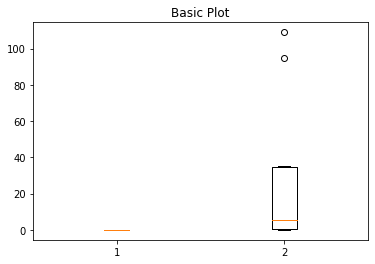

In [110]:
for claz in CLASES:
    coveragess = [
        coverages_old[claz],
        coverages_new[claz]
    ]
    
    print("#### CLASS:" + claz + "####")
#     print("stats data for new coverage")
#     print(coverages_new[claz])
#     print(stats.describe(coverages_new[claz]))
#     print("stats data for old coverage")
#     print(coverages_old[claz])
#     print(stats.describe(coverages_old[claz]))

    fig1, ax1 = plt.subplots()
    ax1.set_title('Basic Plot')
    ax1.boxplot(coveragess)
    plt.show()

# Other Metrics


# Data showoff

### First case
At first glance, generate the two columns for comparing the coverage and time data for the statistical tests.

In [7]:

TotalNumberOfConstraints_old = dict()
TotalNumberOfConstraints_new = dict()

TotalTimeSpentExecutingConcolicaly_old = dict()
TotalTimeSpentExecutingConcolicaly_new = dict()

AvgPathConditionLength_old = dict()
AvgPathConditionLength_new = dict()

NumberOfPathsExplored_old = dict()
NumberOfPathsExplored_new = dict()

NumberOfPathsDiverged_old = dict()
NumberOfPathsDiverged_new = dict()

TotalTimeSpentSolvingConstraints_old = dict()
TotalTimeSpentSolvingConstraints_new = dict()

coverages_old = dict()
coverages_new = dict()

TotalTimeSpentExecutingTestCases_old = dict()
TotalTimeSpentExecutingTestCases_new = dict()

TotalTimeSpentExecutingNonConcolicTestCases_old = dict()
TotalTimeSpentExecutingNonConcolicTestCases_new = dict()

for claz in CLASES:
    TotalNumberOfConstraints_old[claz] = []
    TotalNumberOfConstraints_new[claz] = []

    TotalTimeSpentExecutingConcolicaly_old[claz] = []
    TotalTimeSpentExecutingConcolicaly_new[claz] = []

    AvgPathConditionLength_old[claz] = []
    AvgPathConditionLength_new[claz] = []

    NumberOfPathsExplored_old[claz] = []
    NumberOfPathsExplored_new[claz] = []

    NumberOfPathsDiverged_old[claz] = []
    NumberOfPathsDiverged_new[claz] = []

    TotalTimeSpentSolvingConstraints_old[claz] = []
    TotalTimeSpentSolvingConstraints_new[claz] = []

    coverages_old[claz] = []
    coverages_new[claz] = []

    TotalTimeSpentExecutingTestCases_old[claz] = []
    TotalTimeSpentExecutingTestCases_new[claz] = []
    
    TotalTimeSpentExecutingNonConcolicTestCases_old[claz] = []
    TotalTimeSpentExecutingNonConcolicTestCases_new[claz] = []
    
    
for claz in CLASES:

#     TotalNumberOfConstraints_old[claz] = TotalNumberOfConstraints_old[claz] + data[claz]["TotalNumberOfConstraints"]["old_algorithm"]
#     TotalNumberOfConstraints_new[claz] = TotalNumberOfConstraints_new[claz] + data[claz]["TotalNumberOfConstraints"]["old_algorithm"]
    
    TotalTimeSpentExecutingConcolicaly_old[claz] = TotalTimeSpentExecutingConcolicaly_old[claz] + data[claz]["TotalTimeSpentExecutingConcolicaly"]["old_algorithm"]
    TotalTimeSpentExecutingConcolicaly_new[claz] = TotalTimeSpentExecutingConcolicaly_new[claz] + data[claz]["TotalTimeSpentExecutingConcolicaly"]["old_algorithm"]
    
    AvgPathConditionLength_old[claz] = AvgPathConditionLength_old[claz] + data[claz]["AvgPathConditionLength"]["old_algorithm"]
    AvgPathConditionLength_new[claz] = AvgPathConditionLength_new[claz] + data[claz]["AvgPathConditionLength"]["old_algorithm"]
    
    NumberOfPathsExplored_old[claz] = NumberOfPathsExplored_old[claz] + data[claz]["NumberOfPathsExplored"]["old_algorithm"]
    NumberOfPathsExplored_new[claz] = NumberOfPathsExplored_new[claz] + data[claz]["NumberOfPathsExplored"]["old_algorithm"]
    
    NumberOfPathsDiverged_old[claz] = NumberOfPathsDiverged_old[claz] + data[claz]["NumberOfPathsDiverged"]["old_algorithm"]
    NumberOfPathsDiverged_new[claz] = NumberOfPathsDiverged_new[claz] + data[claz]["NumberOfPathsDiverged"]["old_algorithm"]
    
    TotalTimeSpentSolvingConstraints_old[claz] = TotalTimeSpentSolvingConstraints_old[claz] + data[claz]["TotalTimeSpentSolvingConstraints"]["old_algorithm"]
    TotalTimeSpentSolvingConstraints_new[claz] = TotalTimeSpentSolvingConstraints_new[claz] + data[claz]["TotalTimeSpentSolvingConstraints"]["old_algorithm"]
    
    # Coverages     
    coverages_old[claz] = coverages_old[claz] + data[claz]["Coverage"]["old_algorithm"]
    coverages_new[claz] = coverages_new[claz] + data[claz]["Coverage"]["new_algorithm"]
    
    # TotalTimeSpentExecutingTestCases
    TotalTimeSpentExecutingTestCases_old[claz] = TotalTimeSpentExecutingTestCases_old[claz] + data[claz]["TotalTimeSpentExecutingTestCases"]["old_algorithm"]
    TotalTimeSpentExecutingTestCases_new[claz] = TotalTimeSpentExecutingTestCases_new[claz] + data[claz]["TotalTimeSpentExecutingTestCases"]["new_algorithm"]
    

# # Cleaning up clases that ran well on one sido but not on the other
# coverages_old = np.delete(coverages_old,60)
# coverages_new = np.delete(coverages_new,[107, 138])
# times_old = np.delete(times_old,60)
# times_new = np.delete(times_new,[107, 138])

In [39]:
for claz in CLASES:
    print("#### Describing class: {}".format(claz))
    
    if (not (len(coverages_new[claz]) == 0 or len(coverages_old[claz]) == 0)):
        print("coverage_old")
        print(stats.describe(coverages_old[claz]))
        print("coverage_new")
        print(stats.describe(coverages_new[claz]))
    
    if (not (len(times_new[claz]) == 0 or len(times_old[claz]) == 0)):
        print("time_old")
        print(stats.describe(times_old[claz]))
        print("time_new")
        print(stats.describe(times_new[claz]))        

#### Describing class: se.kth.cid.identity.URIClassifier
coverage_old
DescribeResult(nobs=20, minmax=(0.5, 0.5666666666666667), mean=0.5366666666666666, variance=0.00033918128654970744, skewness=0.07683945028016509, kurtosis=0.30202140309155645)
coverage_new
DescribeResult(nobs=20, minmax=(0.5666666666666667, 0.9333333333333332), mean=0.6466666666666666, variance=0.013847953216374262, skewness=1.4709646314695115, kurtosis=1.0883172023374748)


NameError: name 'times_new' is not defined

# Clases resulting in coverage higher than zero

In [25]:
def higher(arr):
    for i in arr:
        if i > 0.0:
            return True
    return False

CLASSES_COVERAGE = []
CLASSES_NO_COVERAGE = []

for claz in CLASES:
    if ( higher(coverages_new[claz]) or higher(coverages_old[claz])):
        CLASSES_COVERAGE.append(claz)
    else:
        CLASSES_NO_COVERAGE.append(claz)
        
print("classes with coverage: {}".format(CLASSES_COVERAGE))
print("classes without coverage: {}".format(CLASSES_NO_COVERAGE))

classes with coverage: ['org.openscience.cdk.index.CASNumber', 'se.kth.cid.identity.URIClassifier', 'com.prowidesoftware.swift.model.IBAN', 'org.joda.time.format.DateTimeFormat']
classes without coverage: ['se.kth.cid.identity.ResourceURL', 'se.kth.cid.identity.URI', 'se.kth.cid.identity.URIUtil', 'se.kth.cid.identity.PathURN', 'se.kth.cid.identity.URN', 'se.kth.cid.identity.MIMEType', 'stempeluhr.validation.TimeChecker', 'org.jxpfw.util.InternationalBankAccountNumber', 'org.jxpfw.util.CLocale', 'com.prowidesoftware.swift.model.BIC', 'com.sun.jndi.toolkit.url.ConcreteURLContext', 'java.util.regex.Pattern', 'java.util.ArrayList', 'org.apache.commons.cli.CommandLine', 'org.jdom.Attribute', 'org.apache.commons.codec.language.DoubleMetaphone', 'org.joda.time.DateTime', 'org.jgrapht.alg.BellmanFordIterator', 'org.apache.commons.math3.transform.FastFourierTransformer', 'net.n3.nanoxml.XMLElement']


# Boxplots for results

In [34]:
import time
from scipy import stats

for claz in CLASSES_COVERAGE:
    print("################## Class: {} ##################".format(claz))
    if (not (len(coverages_new[claz]) == 0 or len(coverages_old[claz]) == 0)):
        coveragess = [
            coverages_old[claz],
            coverages_new[claz]
        ]
        
        print("stats data for new coverage")
        print(coverages_new[claz])
        print(stats.describe(coverages_new[claz]))
        print("stats data for old coverage")
        print(coverages_old[claz])
        print(stats.describe(coverages_old[claz]))

        fig1, ax1 = plt.subplots()
        ax1.set_title('Basic Plot')
        ax1.boxplot(coveragess)
        plt.show()
    else:
        print("========= Fitered =========")
        print(claz)
        print("===========================")
        
    if (not (len(times_new[claz]) == 0 or len(times_old[claz]) == 0)):
        timess = [
            times_old[claz],
            times_new[claz]
        ]
        
        
        print("stats data for new times")
        print(times_new[claz])
        print(stats.describe(times_new[claz]))
        print("stats data for old time")
        print(times_old[claz])
        print(stats.describe(times_old[claz]))
        
        fig2, ax2 = plt.subplots()
        ax2.set_title('Basic Plot')
        ax2.boxplot(timess)
        plt.show()
    else:
        print("========= Fitered =========")
        print(claz)
        print("===========================")

NameError: name 'CLASSES_COVERAGE' is not defined

Clases that contained Coverage were:
    - CASNumber
    - URIClassifier
    - IBAN
    - DateTimeFormat
    
As can be seen coverages were a bit different were the new exploration algorithm performed better at times 
    - CASNumes:
        - new: 0.33
        - old: 0.2
    - URIClassifier
        - new: 0.533
        - old: 0.536
    - IBAN:
        - new: 0.065
        - old: 0.065
    - DateTimeFormat: This is the most interesting case as it contains several static methods which ends up in a lot of paths to explore, the search budget was 180 seconds and it kept having paths to explore after that. Even though coverage was almost 7% less than the old algorithm
        - new: 0.48
        - old: 0.56
        